Experiment: 
What's the correlation between the first N candles and the direction of the N+1th candle? 


Process: 
- Load data
- Transform as such:
  - Date | open | close | delta | UP | DOWN

In [1]:
import pandas as pd

# open all the files in the data directory as dataframes

tickers = ['TSLA']
frames = []

for e in tickers: 
    filename = '../data/' + e + '_1min_firstratedata.csv'
    df = pd.read_csv(filename)
    df['ticker'] = e
    frames.append(df)

df = pd.concat(frames)
df.describe()

,open,high,low,close,volume
count,230816.000000,230816.000000,230816.000000,230816.000000,2.308160e+05
mean,205.326511,205.454606,205.195887,205.325034,1.224857e+05
std,44.188170,44.199151,44.176131,44.188387,2.069744e+05
min,101.220000,101.390000,101.200000,101.220000,1.000000e+02
25%,176.703900,176.840000,176.610000,176.708750,1.822000e+03
50%,198.010000,198.170000,197.850000,198.003250,1.215500e+04
75%,245.190000,245.330000,245.050025,245.190000,1.950722e+05
max,298.936400,299.290000,298.710000,298.960900,1.706185e+07


In [2]:
# Data Preprocessing

# Get the earliest and latest times for each day 
import datetime

df["timestamp"] = pd.to_datetime(df["timestamp"])
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')   

# Crop to market hours
df = df[(df['time'] >= datetime.time(9, 30)) & (df['time'] <= datetime.time(16, 0))]

# Find the indices of the earliest and latest rows for each day
earliest_indices = df.groupby('date')['time'].idxmin()
latest_indices = df.groupby('date')['time'].idxmax()

# Concatenate the indices and drop duplicates
indices_to_keep = pd.concat([earliest_indices, latest_indices]).drop_duplicates()

# Create a new DataFrame with only the selected rows
df = df.loc[indices_to_keep]
df = df.sort_values(by=['date'])
df.drop(['timestamp', 'high', 'low'], axis=1, inplace=True)

df.to_csv('../data/dump.csv', index=False)

In [3]:
# Only include rows that have both an open and close price. 

df = df.groupby(['date', 'time']).filter(lambda group: len(group) != 2)
df.to_csv('../data/dump.csv', index=False)

In [12]:
# Unify data into one row per day

# Separate 'open' and 'close' rows into two DataFrames
open_rows = df[df['time'] == datetime.time(9, 30)][['date', 'open', 'time']]
close_rows = df[df['time'] == datetime.time(16, 0)][['date', 'close', 'time']]

merged_df = pd.merge(open_rows, close_rows, on=['date'])
merged_df['dif'] = merged_df['close'] - merged_df['open']
merged_df['dif'] = merged_df['dif'].round(2)

merged_df["percent_change"] = (merged_df["dif"] / merged_df['open']).round(2)


merged_df['up'] = merged_df['dif'] > 0
merged_df['up'] = merged_df['up'].astype(int)

merged_df.to_csv('../data/merged.csv', index=False)

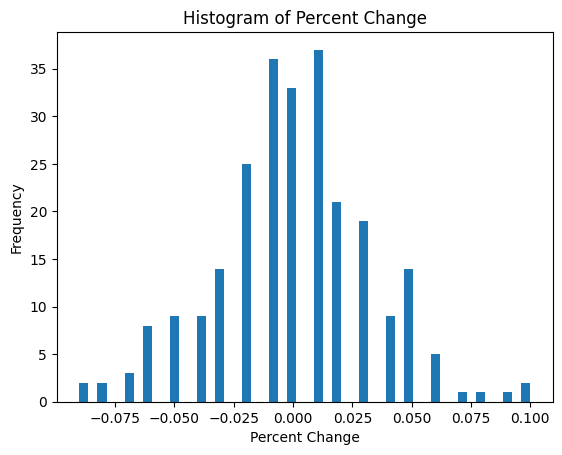

In [16]:
# chart a histogram of the daily percent change

import matplotlib.pyplot as plt
import numpy as np

plt.hist(merged_df['percent_change'], bins=50)
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.title('Histogram of Percent Change')
plt.show()
